# 1. Get started with FragBEST-Myo: Basics of `TrajectoryHandler`
FragBEST-Myo is a specialized version of FragBEST (**Frag**ment-**B**ased protein **E**nsemble semantic **S**egmentation **T**ool). This model is trained using PPS/PR-state cardiac myosin trajectories in the presence of omecamtiv mecarbil (OM). It is designed to predict the protein's surface regions that have the potential to bind with OM's chemical fragments.   

In this tutorial, you will learn how to:  
* Load and analyze trajectories using the `TrajectoryHandler` class.  
* Save files with `TrajectoryHandler`.  
* Make predictions using our pretrained model with `TrajectoryHandler`.  
* Evaluate prediction performance using various metrics.

## Set Up the Environment  
To set up the project path and import the required modules.

In [1]:
# only for once to change the directory to the root of the project
import os
import sys
import warnings


def find_project_root(marker=".git"):
    current_path = os.getcwd()
    while current_path != os.path.dirname(current_path):  # Stop at the filesystem root
        if marker in os.listdir(current_path):
            return current_path
        current_path = os.path.dirname(current_path)
    return None  # Return None if the marker is not found


project_root = find_project_root()
print(project_root)
# this project root should be at the root of the project
# e.g., /.../.../.../FragBEST-Myo

# Add project_root to the Python path
sys.path.append(project_root)

# Ignore warnings
warnings.filterwarnings("ignore")

/home/yuyang/Project_local/FragBEST-Myo


In [2]:
# Import required packages
import pymesh
from IPython.display import Image
from sklearn.metrics import accuracy_score, confusion_matrix, jaccard_score

from utils.datasets.general import read_model
from utils.datasets.traj_handler import TrajectoryHandler
from utils.ppseg.dataset import load_h5
from utils.ppseg.visualization.visualization import plot_confusion_matrix
from utils.pymol_scripts.vis_pdb_ply import generate_pse

## Learn to use Trajectory Handler  

The `TrajectoryHandler` simplifies the process of analyzing your trajectory or PDB files. In this section, you will learn how to use the provided example files to analyze data with `TrajectoryHandler`.  

**Table of Contents** 
* [Read the trajectory](#read-the-trajectory) 
* Preparation for prediction  
    1. [Get/Read the **pocket center**](#get-read-the-pocket-center) 
        * [Extract the pocket center from a ligand-containing trajectory](#a-get-the-pocket-center-from-a-ligand-in-the-trajectory)  *(Requires a ligand in the topology file)*  
        * [Save pocket information to an auxiliary file](#b-save-to-an-auxiliary-file)  
        * [Read pocket information from an auxiliary file](#c-read-from-an-auxiliary-file) *(Requires an auxiliary file)*   
        * [Read pocket information from string](#d-read-from-string)    
    2. [Align the trajectory to the pocket](#align-to-the-pocket)  
    3. [Generate necessary files for each conformation from the trajectory](#generate-required-files)  
* [Perform fragment-based segmentation prediction for a specific protein conformation](#predict-the-fragment-based-regions-with-fragbest-myo)  
* [Evaluate fragment-based segmentation predictions](#analyze-prediction-vs-label-in-the-ply-file)  

We provide an MD trajectory from our [Zenodo repository](https://zenodo.org/records/17779759). 

**Example Files:**  
Please download the example files and save them in `FragBEST-Myo/dataset/examples` folder.  
* **Topology**: `PPS_OMB_min_cg_pl.gro` (PPS cardiac myosin with omecamtiv mecarbil, OM)  
* **Trajectory**: `PPS_OMB_300ns_skip10ns.xtc` (300 ns trajectory with a 10 ns interval, ~30 frames)

**Pretrained Model:**
Please download the pretrained model's weights and save it in `FragBEST-Myo/utils/ppseg/utils/myo` folder.  
* **Model**: `Kfold2_best_model_169_miou=0.7525.pt`

### Download the example files (the link will be accessible once the repo is public)

In [ ]:
# Download example files
!wget -O f"{project_root}/dataset/examples/PPS_OMB_min_cg_pl.gro" \
    https://zenodo.org/records/18630776/files/PPS_OMB_min_cg_pl.gro

!wget -O f"{project_root}/dataset/examples/PPS_OMB_300ns_skip10ns.xtc" \
    https://zenodo.org/records/18630776/files/PPS_OMB_300ns_skip10ns.xtc

!wget -O f"{project_root}/utils/ppseg/utils/myo/Kfold2_best_model_168_miou=0.7525.pt" \
    https://zenodo.org/records/18630776/files/Kfold2_best_model_168_miou=0.7525.pt


```{note}
The provided trajectory file is solely for demonstrating how to use `TrajectoryHandler` to process your data. Typically, your trajectory should have a 100-ps interval to ensure that the sampling of protein conformations is not too sparse.

```

### Read the trajectory
In `TrajectoryHandler`, three key parameters are required during initialization:  
* **`top_path`**: The path to the topology file.  
* **`traj_path`**: The path to the trajectory file (set to `None` if you only want to analyze a PDB file).  
* **`ligand_name`**: The name of the ligand in the topology file (set to `None` if there is no ligand in your topology file).  

In the example files provided, the ligand name for OM is `2OW`.

```{attention}
It is recommended to use an absolute path to indicate the file, especially when generating the surface files.
```

In [4]:
# -------------------- Start of user-defined variables --------------------
output_dir = f"{project_root}/dataset/examples/outputs"
# Create the output directory for storing any output files generated in this tutorial

# Required parameters for TrajectoryHandler
top_path = f"{project_root}/dataset/examples/PPS_OMB_min_cg_pl.gro"  # Topology file
traj_path = (
    f"{project_root}/dataset/examples/PPS_OMB_300ns_skip10ns.xtc"  # Trajectory file
)
ligand_name = "2OW"  # Name of the ligand in the topology file

# Optional parameters for TrajectoryHandler
radius_of_interest = 16
# -------------------- End of user-defined variables ----------------------

# Create the output directory if it doesn't already exist
os.makedirs(output_dir, exist_ok=True)

# Load the trajectory using TrajectoryHandler
traj_handler = TrajectoryHandler(
    top_path,
    traj_path,
    ligand_name=ligand_name,
    radius_of_interest=radius_of_interest,
)

2OW is in the trajectory


There are some optional settings can be adjusted, such as `warning_check`, `radius_of_interest`, `spacing`, and `distance_cutoff`.  For the sake of keeping this tutorial concisely, you can find more details [here](./supplementary/fragbest_cheatsheet.md#modify-initial-optional-settings).  

The trajectory management is handled using `MDAnalysis`. For more information on how to manipulate trajectories, refer to the [MDAnalysis User Guide](https://userguide.mdanalysis.org/2.8.0/).

In [5]:
traj_handler.universe
# This is an MDAnalysis universe object.

<Universe with 12624 atoms>

### Preparation for prediction
The preparation for prediction involves three crucial steps:  
1. Determine the pocket center (either get it from the trajectory or read it from an auxiliary file).  
2. Align the entire trajectory to the pocket.  
3. Generate the necessary files for prediction.

#### 1. Get/Read the pocket center
In this study, the **pocket center** is crucial because the **region of interest** for subsequent analyses is defined based on this center. 


##### a. Get the pocket center from a ligand in the trajectory 
> This method is highly useful when working with a trajectory or PDB file that **contains a ligand**.

The function `TrajectoryHandler.get_pocket_center()` is used to calculate the pocket center, which is determined by computing the geometric center of the atoms in the selected residues near the pocket at a specific frame. Prior to calling `TrajectoryHandler.get_pocket_center()`, two dependent functions are executed in the background:  

1. **`TrajectoryHandler.get_residues_at_pocket()`**:  
   This function identifies the residues at the pocket based on their distance from the ligand (`ligand_aa_dist=5` by default, unit: **Å**; refer to advanced usage below) and their presence over time in the trajectory (`aa_existence_time=0.5` by default, meaning the residues must be present for at least **50%** of the trajectory). The outputs of this function are the residue IDs at the pocket, stored as `self.residues_at_pocket` (in list format) and `self.residues_at_pocket_str` (in string format).

2. **`TrajectoryHandler.get_pocket_residues()`**:  
   This function retrieves the `MDAnalysis` atom selection of those residues at the pocket (based on `resid`) and stores it in `self.pocket_residues`.

Finally, the pocket center is calculated using the `TrajectoryHandler.get_pocket_center()` function. A specific reference frame number (`frame`) is provided to indicate which frame will be used for the calculation. The results are saved as `self.pocket_center` (in list format) and `self.pocket_center_str` (in string format) for easy access.

```{note}
If the input is a PDB file, the residues near the ligand are directly considered as pocket residues, without using their presence over time in the MD trajectory (ignoring `aa_existence_time`).
```

In [6]:
# ---------- Start of user-defined variables ----------
ref_frame_to_pocket_center = 0
# ---------- End of user-defined variables ----------

# Get pocket center directly with default threshold values
traj_handler.get_pocket_center(frame=ref_frame_to_pocket_center)

print("Residue ID at the pockect:\n" + traj_handler.residues_at_pocket_str)
# the format is "resid1 resid2 resid3 ..."

print("Pockect center [x, y, z]:\n", traj_handler.pocket_center)
# the unit is Angstrom (Å)

Residue ID at the pockect:
120 146 147 148 160 163 164 167 168 492 497 500 666 667 710 711 712 713 721 722 762 765 767 770 771 774
Pockect center [x, y, z]:
 [47.70839226651354, 106.92862156459263, 64.13315486259201]


Here, we get the pocket center `47.71 106.93 64.13` (if in two decimal digits).   



Let's also check `self.pocket_residues` (a `MDAnalysis` AtomGroup).   

In [7]:
traj_handler.pocket_residues

<AtomGroup with 441 atoms, with selection 'protein and (resid 120 or resid 146 or resid 147 or resid 148 or resid 160 or resid 163 or resid 164 or resid 167 or resid 168 or resid 492 or resid 497 or resid 500 or resid 666 or resid 667 or resid 710 or resid 711 or resid 712 or resid 713 or resid 721 or resid 722 or resid 762 or resid 765 or resid 767 or resid 770 or resid 771 or resid 774)' on the entire Universe.>

##### b. Save to an auxiliary file
The pocket information, including the **residue IDs** of pocket residues and **the coordinates** of the pocket center, can be stored in an auxiliary file for future use.

In [8]:
# ---------- Start of user-defined variables ----------
aux_output_path = f"{output_dir}/pocket_center.txt"
# ---------- End of user-defined variables ------------

# the resid and pocket center is written to the file
traj_handler.write_pocket_aux_file(aux_output_path)

In [9]:
# check the content of the auxiliary file: pocket_center.txt
!cat {aux_output_path}

BindingResidueIDs:120 146 147 148 160 163 164 167 168 492 497 500 666 667 710 711 712 713 721 722 762 765 767 770 771 774
BindingSiteCenter:47.70839226651354 106.92862156459263 64.13315486259201


````{note}
If your input PDB contains multiple chains, it might look like this:

```txt
BindingResidueIDs:B_146 B_147 B_160 B_163 B_164 B_167 B_168 B_170 B_492 B_497 B_666 B_667 B_710 B_711 B_712 B_713 B_721 B_722 B_765 B_770 B_771 B_774
BindingSiteCenter:-20.753120722733144 -37.50612596326613 22.073186381282454
```

Here, the `BindingResidueIDs` row includes both the chain ID (`segid` in `MDAnalysis`) and the residue ID (`resid` in `MDAnalysis`).
````

##### c. Read from an auxiliary file

> This method is commonly used by users to manually define the pocket.

The pocket center is determined using an auxiliary file. Please note that the auxiliary file for the pocket is **always** to be **a two-line text file** even if there is no data (see the example below). 

* The first line **must** start with `BindingResidueIDs:` and is followed by `resid` with *space seperation*.   
* The second line **must** start with `BindingSiteCenter:` and is followed by the `xyz` coordiantes of the pocket center in Cartesian coordiates with *space seperation*.  

An example of a valid auxiliary file:

```txt
BindingResidueIDs:120 146 147 148 160 163 164 167 168 492 497 500 666 667 710 711 712 713 721 722 762 765 767 770 771 774
BindingSiteCenter:
```

Here, we demonstrate this using example files from `FragBEST-Myo/utils/ppseg/myo` folder (which contains 3 examples: `pocket_aux_example1.txt`, `pocket_aux_example2.txt`, and `pocket_aux_example3.txt`).


###### Example 1: Containing both `BindingResidueIDs` and `BindingSiteCenter`

You can provide a complete file containing both `BindingResidueIDs` and `BindingSiteCenter`. This information will be directly loaded into the `TrajectoryHandler`'s variables, updating `self.pocket_center`, `self.pocket_center_str`, `self.residues_at_pocket`, `self.residues_at_pocket_str`, and `self.pocket_residues`.

```{hint}
If you prepare your auxiliary file manually or from another trajectory, we **highly recommend** you to get the pocket center again with our `TrajectoryHandler.get_pocket_center()` function, which will ensure the generated pocket center nearby your input residue IDs.   
```

In [10]:
# -------------------- Start of user-defined variables --------------------
# both pocket center and residues at the pocket
aux_file_path = f"{project_root}/utils/ppseg/myo/pocket_aux_example1.txt"
# -------------------- End of user-defined variables ----------------------

# read the pocket auxiliary file
traj_handler.read_pocket_aux_file(aux_file_path)
print("Original pocket center:", traj_handler.pocket_center)
print("Residues at the pocket:", traj_handler.residues_at_pocket)

# get the pocket center again to ensure the consistency
traj_handler.get_pocket_center()
print("Updated pocket center:", traj_handler.pocket_center)
traj_handler.pocket_residues

Original pocket center: [47.71, 106.93, 64.13]
Residues at the pocket: ['120', '146', '147', '148', '160', '163', '164', '167', '168', '492', '497', '500', '666', '667', '710', '711', '712', '713', '721', '722', '762', '765', '767', '770', '771', '774']
Updated pocket center: [47.70839226651354, 106.92862156459263, 64.13315486259201]


<AtomGroup with 441 atoms, with selection 'protein and (resid 120 or resid 146 or resid 147 or resid 148 or resid 160 or resid 163 or resid 164 or resid 167 or resid 168 or resid 492 or resid 497 or resid 500 or resid 666 or resid 667 or resid 710 or resid 711 or resid 712 or resid 713 or resid 721 or resid 722 or resid 762 or resid 765 or resid 767 or resid 770 or resid 771 or resid 774)' on the entire Universe.>

Alternatively, you can provide either `BindingSiteCenter` or `BindingResidueIDs` in your file:  

- **With only `BindingSiteCenter`** ([example 2](#example-2-with-only-bindingsitecenter)).  
- **With only `BindingResidueIDs`** ([example 3](#example-3-with-only-bindingresidueids)).  


###### Example 2: With only `BindingSiteCenter`
`self.pocket_center` will be initialized from the file. Then,
`self.residues_at_pocket` will be generated by selecting residues within a distance (`self.distance_cutoff`) from `self.pocket_center`. 
```{note} 
This approximate method may underestimate the number of residues in the actual pocket, but it provides a quick way to identify residues near the defined pocket center, especially if no ligand is present in your topology. 
``` 


In [11]:
# -------------------- Start of user-defined variables --------------------
# only pocket center at the pocket
aux_file_path = f"{project_root}/utils/ppseg/myo/pocket_aux_example2.txt"
# -------------------- End of user-defined variables ----------------------

# read the pocket auxiliary file
traj_handler.read_pocket_aux_file(aux_file_path)
print("Pocket center:", traj_handler.pocket_center)
print("Residues at the pocket:", traj_handler.residues_at_pocket)
traj_handler.pocket_residues

Pocket center: [47.71, 106.93, 64.13]
Residues at the pocket: ['120', '164', '666', '711', '712', '770']


<AtomGroup with 114 atoms, with selection 'protein and (resid 120 or resid 164 or resid 666 or resid 711 or resid 712 or resid 770)' on the entire Universe.>

###### Example 3: With only `BindingResidueIDs`
The pocket center will be calculated directly based on the provided residues (residue IDs).

In [12]:
# -------------------- Start of user-defined variables --------------------
# only residues at the pocket
aux_file_path = f"{project_root}/utils/ppseg/myo/pocket_aux_example3.txt"
# -------------------- End of user-defined variables ----------------------

# read the pocket auxiliary file
traj_handler.read_pocket_aux_file(aux_file_path)
print("Pocket center:", traj_handler.pocket_center)
print("Residues at the pocket:", traj_handler.residues_at_pocket)
traj_handler.pocket_residues

Pocket center: [49.28587943629215, 105.34105729220207, 64.71202063978764]
Residues at the pocket: ['120', '146', '147', '148', '160', '163', '164', '167', '168', '492', '497', '500', '666', '667', '710', '711', '712', '713', '721', '722', '762', '765', '767', '770', '771', '774']


<AtomGroup with 441 atoms, with selection 'protein and (resid 120 or resid 146 or resid 147 or resid 148 or resid 160 or resid 163 or resid 164 or resid 167 or resid 168 or resid 492 or resid 497 or resid 500 or resid 666 or resid 667 or resid 710 or resid 711 or resid 712 or resid 713 or resid 721 or resid 722 or resid 762 or resid 765 or resid 767 or resid 770 or resid 771 or resid 774)' on the entire Universe.>

##### d. Read from string
> This is the method for the user to manually define the pocket.

The pocket residues and/or pocket center can also be determined using `string`. Similar to the previous session, we show three scenarios when defining your pocket center and residues.   


In [13]:
# Case 1: both pocket residues and pocket center defined

# -------------------- Start of user-defined variables --------------------
pocket_center = "47 107 64"
residue_str = "120 146 147 148 160 163 164 167 168 492 497 500 666 667 710"
# -------------------- End of user-defined variables ----------------------

print("Original pocket center:", traj_handler.pocket_center)
print("Original residues at the pocket:", traj_handler.residues_at_pocket)

# read from the defined pocket infomation
traj_handler.read_pocket_from_string(
    residues_at_pocket_str=residue_str,
    pocket_center_str=pocket_center,
)

print("Updated pocket center:", traj_handler.pocket_center)
print("Updated residues at the pocket:", traj_handler.residues_at_pocket)

# To ensure the consistency of the pocket center based on the residues in the pocket,
# it is recommended to run `get_pocket_center` before proceeding
# with the following analyses.
traj_handler.get_pocket_center()
print("New pocket center:", traj_handler.pocket_center)

Original pocket center: [49.28587943629215, 105.34105729220207, 64.71202063978764]
Original residues at the pocket: ['120', '146', '147', '148', '160', '163', '164', '167', '168', '492', '497', '500', '666', '667', '710', '711', '712', '713', '721', '722', '762', '765', '767', '770', '771', '774']
Updated pocket center: [47.0, 107.0, 64.0]
Updated residues at the pocket: ['120', '146', '147', '148', '160', '163', '164', '167', '168', '492', '497', '500', '666', '667', '710']
New pocket center: [50.80057148817109, 105.81402907332753, 62.66317362901641]


In [14]:
# Case 2: use merely pocket center

# -------------------- Start of user-defined variables --------------------
defined_pocket_center = "47 108 58"
# -------------------- End of user-defined variables ----------------------

print("Original pocket center:", traj_handler.pocket_center)
print("Original residues at the pocket:", traj_handler.residues_at_pocket)

# read from the defined pocket infomation
traj_handler.read_pocket_from_string(pocket_center_str=defined_pocket_center)

print("Updated pocket center:", traj_handler.pocket_center)

# To ensure the of the residues in the pocket based on the pocket center,
# it is recommended to run `get_residues_at_pocket_by_center` before proceeding
# with the following analyses.
traj_handler.get_residues_at_pocket_by_center()
print("New residues at the pocket:", traj_handler.residues_at_pocket)

Original pocket center: [50.80057148817109, 105.81402907332753, 62.66317362901641]
Original residues at the pocket: ['120', '146', '147', '148', '160', '163', '164', '167', '168', '492', '497', '500', '666', '667', '710']
Updated pocket center: [47.0, 108.0, 58.0]
New residues at the pocket: ['146', '147', '160', '164', '770', '774']


In [15]:
# Case 3: use merely pocket residues

# -------------------- Start of user-defined variables --------------------
residue_str = (
    "120 146 147 148 160 163 164 167 168 492 497 "
    "500 666 667 710 711 712 713 721 722 762 765 "
    "767 770 771 774"
)
# -------------------- End of user-defined variables ----------------------

print("Original residues at the pocket:", traj_handler.residues_at_pocket)
print("Original pocket center:", traj_handler.pocket_center)

# read from the defined pocket infomation
traj_handler.read_pocket_from_string(residues_at_pocket_str=residue_str)

print("Updated residues at the pocket:", traj_handler.residues_at_pocket)

# To ensure the consistency of the pocket center based on the residues in the pocket,
# it is recommended to run `get_pocket_center` before proceeding
# with the following analyses.
traj_handler.get_pocket_center()
print("New pocket center:", traj_handler.pocket_center)

Original residues at the pocket: ['146', '147', '160', '164', '770', '774']
Original pocket center: [47.0, 108.0, 58.0]
Updated residues at the pocket: ['120', '146', '147', '148', '160', '163', '164', '167', '168', '492', '497', '500', '666', '667', '710', '711', '712', '713', '721', '722', '762', '765', '767', '770', '771', '774']
New pocket center: [47.70839226651354, 106.92862156459263, 64.13315486259201]


#### 2. Align to the pocket
Once the pocket center is identified, it is recommended to align your trajectory to that center (using the pocket residues). **This helps maintain consistency in the region of interest throughout the entire trajectory.** Make sure to use **the same frame number** that was used to calculate the pocket center in the previous step.  

The aligned trajectory will be stored in memory and will replace the original trajectory in `self.universe`.

In [16]:
# -------------------- Start of user-defined variables --------------------
reference = 0  # the frame number in the trajectory to be used as reference to align
# -------------------- End of user-defined variables ----------------------

traj_handler.align_traj_to_pocket(reference=reference)

The pocket center has been updated to [47.70839226651354, 106.92862156459263, 64.13315486259201] after the alignment.


See more examples [here](./supplementary/fragbest_cheatsheet.md#align-trajectory-using-mdanalysis-object-as-the-reference) to learn how to use the MDAnalysis object as the reference structure. 
If you would like to save the aligned trajectory, see [here](./supplementary/fragbest_cheatsheet.md#save-aligned-trajectory) for details.

#### 3. Generate required files
This section explains how to prepare the required files for each conformation in a trajectory before prediction. Here, we only prepare one frame fo the demonstration. In theory, you will need to prepared files the whole trajectory, so we will show you how to prepare files with multiple processors to speed up.


```{seealso}
**Holo-like Conformation Detection:**  

To detect holo-like conformations, the entire trajectory needs to be split into individual files, with each file evaluated separately by the model.  

Due to the relatively high computational cost, it is recommended to use **multiple threads** with parallel processing for this step. Detailed instructions for parallel processing can be found in [Tutorial 3](./03_holo_like_form_detect.ipynb).
```


The process involves the following steps:  
1. **Save the trajectory in PDB format** for each frame.  
2. **Generate a PLY file** (containing protein surface vertices and chemical features) from the PDB file.  
3. **Create an H5 file** (binary voxelized file) from the PLY file, which is used as input for the deep learning (DL) model to predict.  

**Summary of Required Files:**   
a. **PDB file**: Contains protein-only structure.   
b. **PLY file**: Describes the protein surface and chemical features.    
c. **H5 file**: Binary file for the DL model to read and predict.   

Let's take frame `22` as a demonstration.  


In [15]:
# -------------------- Start of user-defined variables --------------------
frame = 22
# -------------------- End of user-defined variables ----------------------

###### a. PDB file
To generate and save individual PDB files from a trajectory, use the `TrajectoryHandler.write_structure()` function.  

**Parameters:**  
- **`pdb_path`**: Define the output path where the PDB file will be saved.  
- **`frame`**: Specify the specific frame of the trajectory to extract.  
- **`structure_type`**: Choose the type of structure to extract, which can be either `protein`, `ligand`, or `complex`.


**Protein**

Since the focus is on protein conformation, you can save only the `protein` structure by setting `structure_type="protein"` when using `TrajectoryHandler.write_structure()`.

```{note}
You don't need to modify the code even if your protein has multiple chains.
```



In [16]:
# -------------------- Start of user-defined variables --------------------
pdb_path = f"{output_dir}/PPS_{frame}.pdb"

# modify this to "ligand" to write ligand only,
# or "complex" to write both protein and ligand
structure_type = "protein"
# -------------------- End of user-defined variables ----------------------

# protein only
traj_handler.write_structure(
    pdb_path=pdb_path, frame=frame, structure_type=structure_type
)

###### b. PLY file
A PLY file contains the protein surface's vertices and mesh, along with the corresponding chemical features.

We use the protein PDB file to generate the protein surface and its chemical features (following the [MaSIF](https://www.nature.com/articles/s41592-019-0666-6) protocol) and save this information in a PLY file.  

**Step 1: Generate Features and Surfaces**   
Use `TrajectoryHandler.write_features_to_ply()` to compute the surface vertices and chemical features from a PDB file.  
- **`pdb_path`**: Path to the input PDB file.  
- **`ply_path`**: Path to save the output PLY file.  

```{note}
The generation of surface vertices and features takes approximately 1 minute per PDB file, depending on the protein size. The main bottleneck is the APBS calculation, which may be optimized in the future.
```

**Step 2: Add Region of Interest (Mask)**  
Use `TrajectoryHandler.add_interest_region_to_ply()` to add a mask indicating the region of interest to the PLY file. It is noted that we defines:
* `1`: within the region of interest.
* `0`: outside the region of interest.


In [17]:
# -------------------- Start of user-defined variables --------------------
pdb_path = f"{output_dir}/PPS_{frame}.pdb"
ply_path = f"{output_dir}/PPS_{frame}.ply"
# -------------------- End of user-defined variables ----------------------

# save features to ply
# it is normal to take 1 mins to get the features
traj_handler.write_features_to_ply(pdb_path=pdb_path, ply_path=ply_path, frame=frame)

# add regions of interest to ply
traj_handler.add_interest_region_to_ply(ply_path=ply_path)

Using the PDB file: /home/yuyang/Project_local/FragBEST-Myo/dataset/examples/outputs/PPS_22.pdb


**Step 3: Add Groud-Truth labels (Optional and only available for ligand-bound trajectory)**   
Fragment information includes the name, atom indices and molecular weights for each fragment. In FragBEST-Myo, the model is trained on these fragments, you don't have to create a fragment information file in default. 

If there is a OM in your trajectory, you can use `TrajectoryHandler.add_labels_to_ply()` to add the ground-truth label for each vertices by the default fragment information in the PLY file. The function will label your protein vertices with the closet corresponding fragment. If the distance from the vertex to the fragment is greater than `distance_cutoff`, the label of the vertex will be assigned to 0 (background).

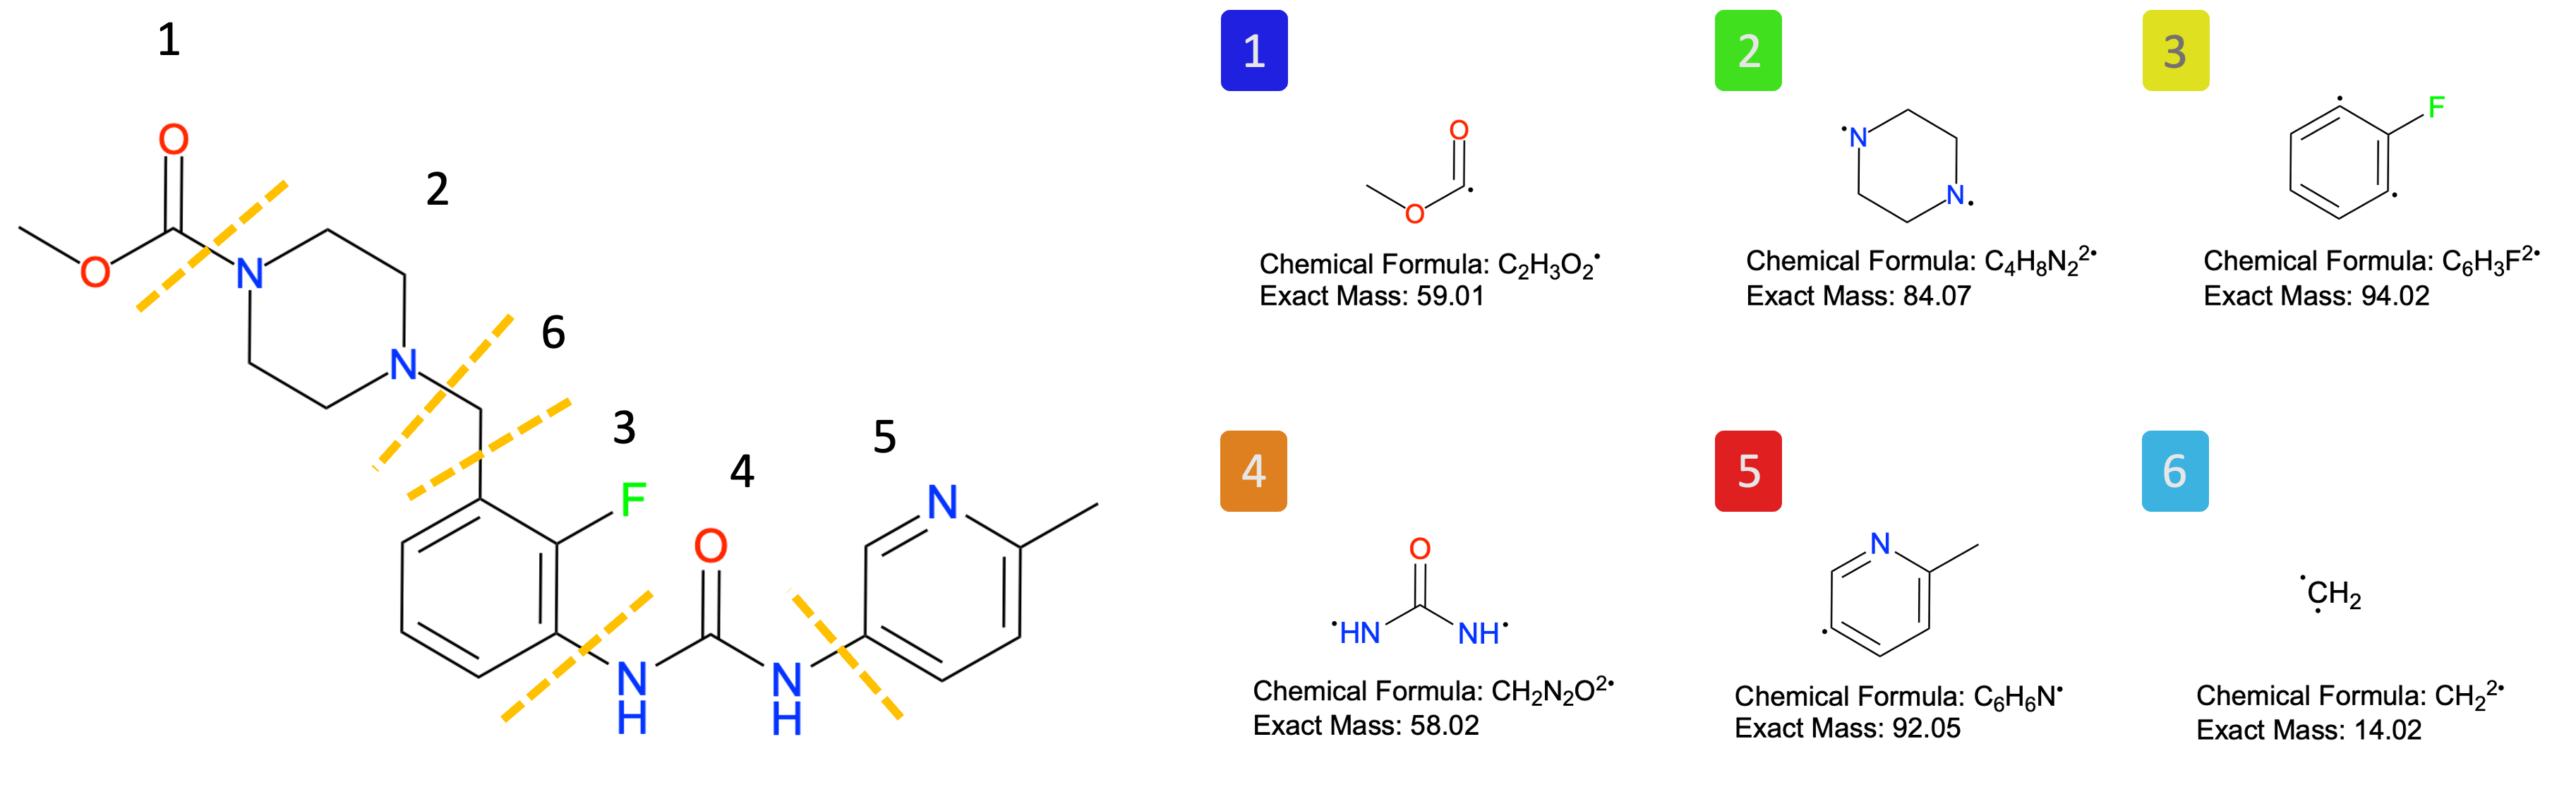

In [18]:
# Here is an image showing the fragments of OM used in this study.
Image(filename=f"{project_root}/imgs/OM_fragment.png")

In [19]:
# (optional)
# add labels to ply (only for ligand-existing trajectory)
traj_handler.read_fragment_aux_file()
traj_handler.add_labels_to_ply(ply_path=ply_path, ref_ligand_frame=frame)


If you wish to prepare/modify the fragmet auxiliary file, check [here](./supplementary/01a_fragmentation.ipynb) to learn how to prepare it. 


**Inside the PLY file**
Let’s explore the contents of a PLY file. The PLY file is managed by `PyMesh`. For more details about how to use the `PyMesh` package, refer to the [documentation](https://pymesh.readthedocs.io/en/latest/).  

To load the PLY file, simply use the following command:  

In [20]:
# -------------------- Start of user-defined variables --------------------
ply_path = f"{output_dir}/PPS_{frame}.ply"
# -------------------- End of user-defined variables ----------------------

# load the ply file
regular_mesh = pymesh.load_mesh(ply_path)

To check what has been saved in the PLY file, you can use:  

In [21]:
regular_mesh.get_attribute_names()

['face_vertex_indices',
 'vertex_charge',
 'vertex_hbond',
 'vertex_hphob',
 'vertex_interest',
 'vertex_label',
 'vertex_nx',
 'vertex_ny',
 'vertex_nz',
 'vertex_x',
 'vertex_y',
 'vertex_z']

From the outputs, we can see that several attributes are saved in the PLY file, including:

- **`face_vertex_indices`**: The indices of the vertices that define a face on the mesh.
- **`vertex_charge`**: The electrostatic potentials for the vertices.
- **`vertex_hbond`**: The hydrogen bond potentials for the vertices.
- **`vertex_hphob`**: The hydrophobic interactions for the vertices.
- **`vertex_interest`**: The binary mask indicating the region of interest for the vertices.
- **`vertex_label`**: The ground-truth labels assigned to the vertices (if applicable).
- **`vertex_nx`**: The x-component of the vertices' normal vector.
- **`vertex_ny`**: The y-component of the vertices' normal vector.
- **`vertex_nz`**: The z-component of the vertices' normal vector.
- **`vertex_x`**: The x-coordinate of the vertices.
- **`vertex_y`**: The y-coordinate of the vertices.
- **`vertex_z`**: The z-coordinate of the vertices. 
- **`vertex_pred`**: The predicted labels assigned to the vertices (if applicable). 
- **`vertex_predprobs`**: The probability of predicted labels assigned to the vertices (if applicable). 

To retrieve the saved attributes for further usage, use `self.get_attribute()`. Here's an example:  

In [22]:
print(regular_mesh.get_attribute("vertex_charge"))
print("Shape:", regular_mesh.get_attribute("vertex_charge").shape)

[ 0.155419  0.190258  0.455629 ...  0.372979  0.268005 -0.279566]
Shape: (15099,)


##### c. H5 file
The H5 file, which contains voxelized features and/or labels, is a binary file designed for deep learning (DL) models. The surface vertices from the PLY file are transformed into an H5 file using the function: `TrajectoryHandler.write_voxelised_data_to_h5()`.  

**Parameters:**  
- **`ply_path`**: The input PLY file path.  
- **`h5_path`**: The output H5 file path.  
- **`with_label`**: Set to `True` to include labels in the H5 file if labels are present.  

```{note}
- There is a slight difference between the original vertices and the voxelized points, depending on the resolution (or the spacing between voxelized points).  
- In some cases, multiple vertices may align to the same voxelized grid point. If this happens, only the information from the closest vertex is retained. 
- In the example below, all vertices are successfully converted into different voxelized points (grid points). 
```

In [23]:
# -------------------- Start of user-defined variables --------------------
ply_path = f"{output_dir}/PPS_{frame}.ply"
h5_path = f"{output_dir}/PPS_{frame}.h5"
with_label = True
# -------------------- End of user-defined variables ----------------------

# write voxelised data to h5
traj_handler.write_voxelised_data_to_h5(
    ply_path=ply_path, h5_path=h5_path, with_label=with_label
)

Including features in the voxel representation
Number of vertices assigned to the same grid: 0
Number of existing points in the voxel: 1047


**Inside the H5 file**   
The H5 file can be loaded using the `load_h5` function, which is based on the `h5py` package. When loaded, the H5 data is returned as a `tuple` with two items:  

1. **First item**: The data.  
2. **Second item**: The label (if applicable).  

**Data Format in FragBEST-Myo:**
Since the **default radius of interest** is set to `16.0 Å`, the diameter of the box becomes `32 Å`. With a **spacing of 0.5 Å** (resolution) between voxelized points, the data dimension in each axis (depth, width, height) is **64**.

- **Data shape**: `4 x 64 x 64 x 64`  
  - This corresponds to 4 channels:  
    - **3 chemical features**: `charge` (electrostatic potentials), `hbond` (hydrogen bond potentials), and `hphob` (hydrophobic interactions).  
    - **1 region of interest mask**: `interest`.  

- **Label shape**: `64 x 64 x 64`  
  - The label corresponds to voxelized points in the same grid dimensions as the data.

In [24]:
# -------------------- Start of user-defined variables --------------------
h5_path = f"{output_dir}/PPS_{frame}.h5"
# -------------------- End of user-defined variables ----------------------


# load the h5 file
h5_data = load_h5(h5_path)

print("Data's shape:", h5_data[0].shape)
print("Label's shape:", h5_data[1].shape)

Data's shape: (4, 64, 64, 64)
Label's shape: (64, 64, 64)


##### (all-in-one) Generate files from PDB to H5

The function `TrajectoryHandler.preprocess_workflow()` is a simplified method to convert data from **PDB** format to **PLY** and **H5** formats.  

This function streamlines the preprocessing workflow, handling the conversion and voxelization processes efficiently.

In [ ]:
# -------------------- Start of user-defined variables --------------------
pdb_path = f"{output_dir}/PPS_{frame}.pdb"
ply_path = f"{output_dir}/PPS_{frame}.ply"
h5_path = f"{output_dir}/PPS_{frame}.h5"
# -------------------- End of user-defined variables ----------------------

# All in one (PDB, PLY, H5)
traj_handler.read_fragment_aux_file()
traj_handler.preprocess_workflow(
    pdb_path=pdb_path, ply_path=ply_path, h5_path=h5_path, frame=frame, with_label=True
)  # "with_label" is only for ligand-existing trajectory

Writing the PDB file: 22 completed
Using the PDB file: /home/yuyang/Project_local/FragBEST-Myo/dataset/examples/outputs/PPS_22.pdb
Writing the PLY file with the features and labels: 22 completed
Including features in the voxel representation
Number of vertices assigned to the same grid: 0
Number of existing points in the voxel: 971
Writing the h5 file: 22 completed


### Predict the fragment-based regions with FragBEST-Myo

The model's predictions can be integrated into the PLY file. To accomplish this, you need:  
* A prepared **PLY file** and **H5 file**.  
* A **well-trained model** for prediction.  


**Steps to Predict Potential Fragment Binding and Add to PLY**  

1. **Load Pretrained Model**:  
   Use the pretrained **FragBEST-Myo** model located at: ```FragBEST-Myo/utils/ppseg/myo/Kfold2_best_model_169_miou=0.7525.pt```.

2. **Add Predictions to PLY File**:  
   Use the function: ```TrajectoryHandler.add_prediction_to_ply(ply_file, h5_file, model)```  
   - **`ply_path`**: Path to the input PLY file.  
   - **`h5_path`**: Path to the corresponding H5 file required for prediction.  
   - **`model`**: The pretrained FragBEST-Myo model.  
   - **`ply_path_output`**: Path to the output PLY file. If it is `None`, the path to output PLY file will be the same as the input PLY file.  


This process enables the addition of fragment-based predictions to the PLY file, enriching it with model-generated insights.

In [25]:
# -------------------- Start of user-defined variables --------------------
model_path = f"{project_root}/utils/ppseg/myo/Kfold2_best_model_169_miou=0.7525.pt"
ply_path_with_pred = f"{output_dir}/PPS_{frame}_with_pred.ply"
# -------------------- End of user-defined variables ----------------------

# Load model and parameters
model = read_model(model_path)

traj_handler.add_prediction_to_ply(
    ply_path=ply_path,
    h5_path=h5_path,
    model=model,
    ply_path_output=ply_path_with_pred,
)

## Analyze Prediction vs Label in the PLY File  
Now, we have the ground-truth label and prediction for a specific frame. They are now saved in the PLY file. 

To evaluate the quality of predictions compared to the label, you can analyze both by loading them from the PLY file. This helps to understand the model's performance in predicting fragment binding potential.

**Steps to Analyze Prediction and Label**  

1. **Extract Groud-truth Label and Prediction**:  
   - First, extract the **label** and **prediction** from the mesh object within the PLY file.  
   - This allows you to access the relevant data for comparison.

2. **Filter Points Using `vertex_interest` Mask**:  
   - Use the mask from **`vertex_interest`** to isolate points within the **region of interest** (`1`: within the region, `0`: outside the region).
   - Only the points within this region are retained for analysis.  

By focusing on the region of interest, the comparison between the prediction and label becomes more meaningful, as it excludes irrelevant areas outside the scope of the model's intended focus.

In [26]:
# -------------------- Start of user-defined variables --------------------
ply_path_with_pred = f"{output_dir}/PPS_{frame}_with_pred.ply"
# -------------------- End of user-defined variables ----------------------

regular_mesh = pymesh.load_mesh(ply_path_with_pred)

# read the region of interest from the ply file
mask = regular_mesh.get_attribute("vertex_interest")

# read the labels from the ply file
label = regular_mesh.get_attribute("vertex_label")
label = label[mask == 1]

# read the prediction from the ply file
pred = regular_mesh.get_attribute("vertex_pred")
pred = pred[mask == 1]

The model also provides **prediction probabilities**, which are recorded in the PLY file. Let’s start by checking these probabilities.

In [27]:
# read the prediction probabilities from the ply file
predprobs = regular_mesh.get_attribute("vertex_predprobs")
predprobs = predprobs[mask == 1]

# the prediction probabilities for each class from the model
for i in range(7):
    mean_probs = predprobs[pred == i].mean()
    print(f"Class {i}: {mean_probs:.4f}")

# the overall prediction probabilities from the model
print(f"Overall: {predprobs.mean():.4f}")

Class 0: 0.9981
Class 1: 0.9953
Class 2: 0.9990
Class 3: 0.9998
Class 4: 1.0000
Class 5: 0.9954
Class 6: 0.9838
Overall: 0.9977


The individual and overall prediction probabilities demonstrate the model's high confidence in its predictions. Next, we can evaluate the prediction accuracy by calculating the **intersection over union (IoU)** for each class (from class `0` to `6`) and the **mean IoU (mIoU)**.

In [28]:
# the accuracy of the prediction
acc = accuracy_score(label, pred)
print(f"Accuracy: {acc:.2f}")

# calculate the IoU for each class
iou = jaccard_score(label, pred, average=None)
print("IoU", [f"{each:.2f}" for each in iou])

# calculate the mean IoU
miou = iou.mean()
# or use:
# miou = jaccard_score(label, pred, average='macro')
print(f"mIoU: {miou:.2f}")

Accuracy: 0.97
IoU ['0.98', '0.94', '0.83', '0.82', '0.81', '0.91', '0.62']
mIoU: 0.84


Another way to assess the model's performance is by using `confusion_matrix()`. In the visualization, the **color** and the **upper number** represent the number of instances (vertices), while the **lower number (with percentage)** indicates the proportion of instances (vertices) in each predicted label to all instances (vertices) within the same ground-truth label group.

For example, there are 650 vertices are predicted correctly in the group with label 0 (background point), which is 98.93% of all vertices with groud-truth label 0 (98.93% accuracy for label 0).

(<Figure size 2700x2100 with 2 Axes>,
 <Axes: xlabel='Prediction', ylabel='Ground Truth'>)

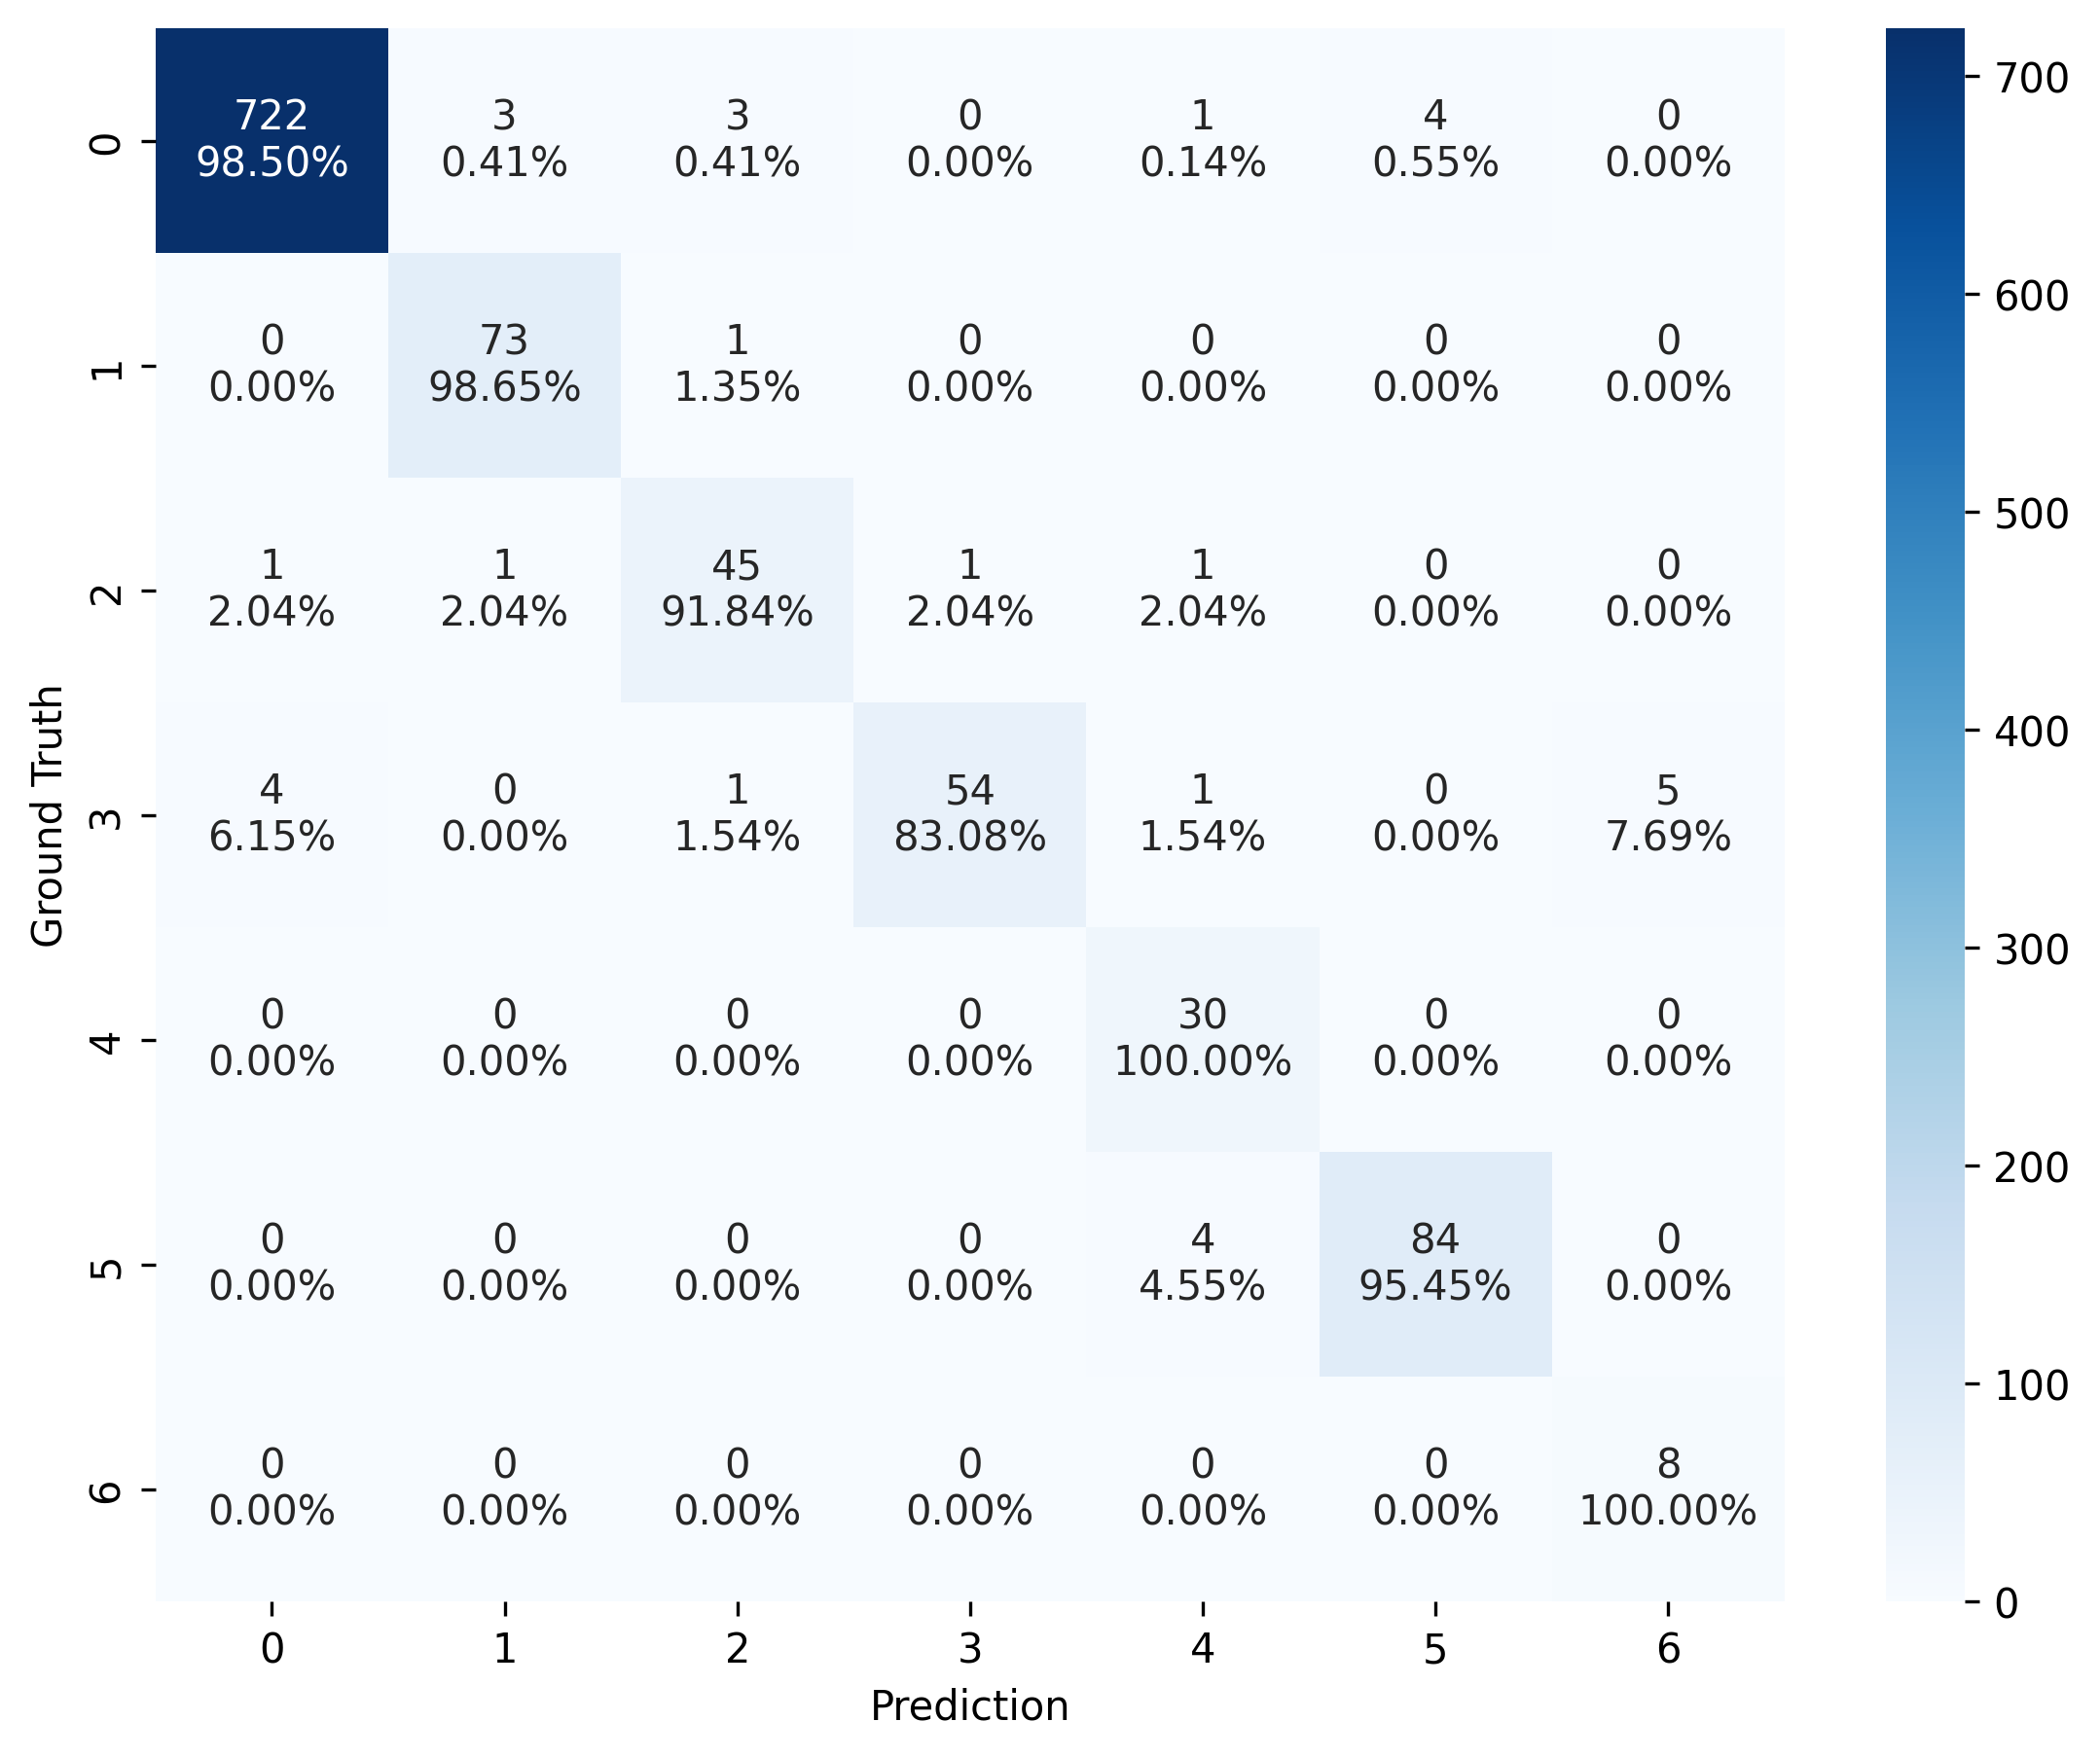

In [29]:
# create confusion matrix
cm = confusion_matrix(label, pred)

# plot confusion matrix
plot_confusion_matrix(cm, normalised_by_row=True)

## Visualization with PyMOL  

We created a PyMOL script to generate a `.pse` file for visualizing the structure. You can use this file to explore the protein structure and its features interactively in PyMOL.  

**Key Features:**
- The PyMOL script utilizes our custom PyMOL plugin: [FragBEST PyMOL Plugin](https://github.com/fornililab/FragBEST_pymol_plugin).  
- This plugin allows you to display:  
  - **Chemical features** for each point on the protein surface.  
  - **Ground-truth labels** for each point on the protein surface (if available).  
  - **Predicted labels** for each point on the protein surface (if available).  
  - **Comparison between ground-truth and predicted labels** for each point on the protein surface (if available). 


### How to Use?
#### Method 1. Generate `.pse` file and visualize in PyMOL.
1. Use the below codes to generate `.pse` file.   
2. Load the `.pse` file generated by the script into PyMOL.   

In [30]:
# -------------------- Start of user-defined variables --------------------
pdb_path = f"{output_dir}/PPS_{frame}.pdb"
ply_path_with_pred = f"{output_dir}/PPS_{frame}_with_pred.ply"

pse_output = f"{output_dir}/PPS_{frame}_visualization.pse"
# -------------------- End of user-defined variables ----------------------

pymol_path = !pixi run -e pymol which pymol
pymol_path = pymol_path[0]
generate_pse(
    pdb_file=pdb_path,
    ply_file=ply_path_with_pred,
    pse_output=pse_output,
    pymol_path=pymol_path,
)  # take about 1 minute to run

interest_pt: 1
ignore_surface: 0
pb_vert_PPS_22_with_pred.ply pb_surf_PPS_22_with_pred.ply hphob_vert_PPS_22_with_pred.ply hphob_surf_PPS_22_with_pred.ply hbond_vert_PPS_22_with_pred.ply hbond_surf_PPS_22_with_pred.ply label_vert_PPS_22_with_pred.ply label_surf_PPS_22_with_pred.ply pred_vert_PPS_22_with_pred.ply pred_surf_PPS_22_with_pred.ply compare_vert_PPS_22_with_pred.ply compare_surf_PPS_22_with_pred.ply mesh_PPS_22_with_pred.ply


#### Method 2. Visualize `.pdb` and `.ply` files in PyMOL with FragBEST PyMOL Plugin. 
1. Install the [FragBEST PyMOL Plugin](https://github.com/fornililab/FragBEST_pymol_plugin) in your PyMOL by following the instructions on the GitHub page. 
2. Use PyMOL to load your protein (`.pdb`) and its surface (`.ply`). See the below example:
    ```pymol
    # in pymol command line
    
    load PPS_22.pdb     # load the protein
    loadply PPS_22.ply  # load the surface, take around 1 minutes

    ```


The visualization helps in understanding the protein's surface properties and holo-like conformations effectively! 

```{note}
In default, the size of each vertex with predicted labels represents suggests the probability of the prediction at that vertex.

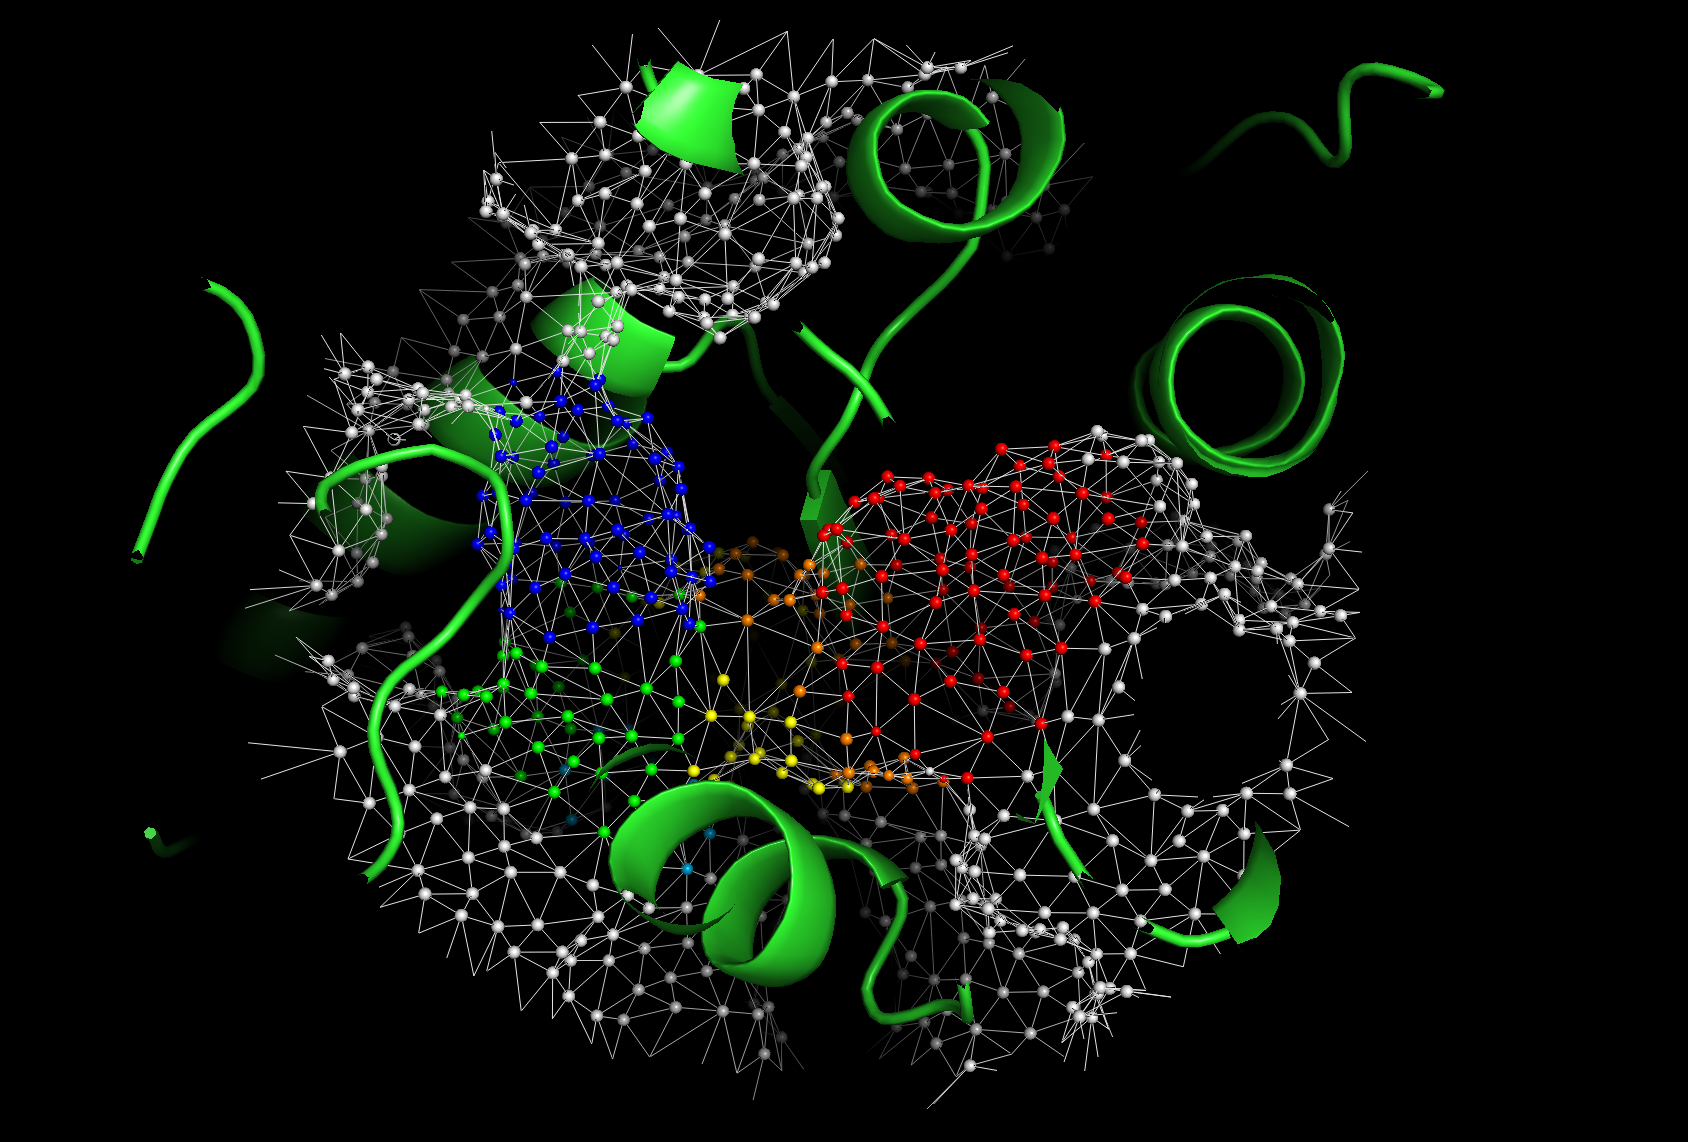

In [31]:
# Here is a screenshot for the pymol visualization.
Image(filename=f"{project_root}/imgs/pymol_vis_01.png")

## Conclusion  

Congratulations! You’ve completed the tutorial and learned how to:  
- Operate trajectories using `TrajectoryHandler`.  
- Utilize our pretrained model to predict potential ligand fragment binding in a PDB file.  
- Perform basic evaluation of the model's predictions.  

Next, you will learn how to analyze a protein ensemble consisting of multiple static structures from **PDB RCSB**. Stay tuned and see you soon in **Tutorial 2**! 🚀